## Lecture 3: Linearization and Autodiff

In [136]:
import jax
import jax.numpy as jnp
import mujoco
import viser
from jax import Array
from matplotlib import pyplot as plt

In [137]:
# Physical constants.
m1 = m2 = 1.0  # masses
l1 = l2 = 1.0  # lengths
g = 9.81       # gravity

def f_double_pendulum_continuous(x: jnp.ndarray, u: jnp.ndarray) -> jnp.ndarray:
    """Continuous-time dynamics of a double pendulum.

    Args:
        x: state [theta1, theta2, theta1_dot, theta2_dot]
        u: control input (torque on first joint) 

    Returns:
        x_dot: time derivative of state
    """
    # Unpack state.
    t1, t2, t1_dot, t2_dot = x

    # Compute some convenience quantities for dynamics.
    delta = t1 - t2
    alpha = m1 + m2 * jnp.sin(delta)**2

    # Implement acceleration dynamics - can derive using Lagrangian mechanics.
    t1_ddot = (-jnp.sin(delta)*(m2*l1 * t1_dot**2 * jnp.cos(delta)) -g * ((m1 + m2) * jnp.sin(t1) - m2 * jnp.sin(t2)* jnp.cos(delta)))/ (l1 * alpha)
    t2_ddot = (jnp.sin(delta) * ((m1+m2)* l1 * t1_dot **2 + m2 * l2 * t2_dot**2 * jnp.cos(delta)) + g * (m1+ m2) * (jnp.sin(t1)* jnp.cos(delta) - jnp.sin(t2)) / (l2 * alpha))

    return jnp.array([t1_dot, t2_dot, t1_ddot, t2_ddot])


In [138]:
def linearize_ad(f: callable, x: Array, u: Array):
    """Exact linearization using Automatic Differentiation.
    
    Args:
        f: dynamics function f(x, u)
        x: state vector
        u: control input vector
    Returns:
        A, B: linearized dynamics matrices
    """
    return jax.jacobian(f, argnums=(0, 1))(x, u)

def linearize_forward(f: callable, x: Array, u: Array, eps: float = 1e-6):
    """Linearization via Forward Difference.
    
    Args:
        f: dynamics function f(x, u)
        x: state vector
        u: control input vector
        eps: perturbation size
    Returns:
        A, B: linearized dynamics matrices
    """
    # Unpack shape and precompute f(x, u)
    n, m = x.shape[0], u.shape[0]
    f0 = f(x, u)

    def get_col_a(i: int):
        """Creates a column of A by perturbing x[i]."""
        dx = jnp.zeros(n).at[i].set(eps)
        return (f(x + dx, u) - f0) / eps

    def get_col_b(j: int):
        """Creates a column of B by perturbing u[j]."""
        du = jnp.zeros(m).at[j].set(eps)
        return (f(x, u + du) - f0) / eps  

    # vmap stacks columns vertically, so we transpose back to (n, n)
    A = jax.vmap(get_col_a)(jnp.arange(n)).T
    B = jax.vmap(get_col_b)(jnp.arange(m)).T
    return A, B

def linearize_central(f: callable, x: Array, u: Array, eps: float = 1e-6):
    """Linearization via Central Difference.
    
    Args: 
        f: dynamics function f(x, u)
        x: state vector
        u: control input vector
        eps: perturbation size
    Returns:
        A, B: linearized dynamics matrices
    """
    # Unpack shape
    n, m = x.shape[0], u.shape[0]

    # Define functions to compute each column of A and B
    def get_col_a(i: int):
        """Creates a column of A by perturbing x[i]."""
        dx = jnp.zeros(n).at[i].set(eps)
        return (f(x + dx, u) - f(x - dx, u)) / (2 * eps)

    def get_col_b(j: int):
        """Creates a column of B by perturbing u[j]."""
        du = jnp.zeros(m).at[j].set(eps)
        return (f(x, u + du) - f(x, u - du)) / (2 * eps)

    # vmap stacks columns vertically, so we transpose back to (n, n)
    A = jax.vmap(get_col_a)(jnp.arange(n)).T
    B = jax.vmap(get_col_b)(jnp.arange(m)).T
    return A, B

## Checking Stability

We can use the AD Jacobians to check the stability of our linearized dynamics. Recall that a continuous-time linear system is stable if all eigenvalues of the system matrix $\bm{A}$ have negative real part. For discrete-time systems, the system is stable if all eigenvalues of $\bm{A}$ have magnitude less than 1.

In [140]:
# Down position equilibrium.
x_eq = jnp.array([0.0, 0.0, 0.0, 0.0])
u_eq = jnp.array([0.0])

A, B = linearize_ad(f_double_pendulum_continuous, x_eq, u_eq)
eigenvalues = jnp.real(jnp.linalg.eigvals(A))
print("Real parts of eigenvalues of A at down position equilibrium:", eigenvalues) # All zero! Marginally stable.

# Up position equilibrium.
x_eq_up = jnp.array([jnp.pi, jnp.pi, 0.0, 0.0])
A_up, B_up = linearize_ad(f_double_pendulum_continuous, x_eq_up, u_eq)
eigenvalues_up = jnp.real(jnp.linalg.eigvals(A_up))
print("Real parts of eigenvalues of A at up position equilibrium:", eigenvalues_up) # Some positive! Unstable.

Real parts of eigenvalues of A at down position equilibrium: [-6.9553096e-08 -6.9553096e-08  1.4540464e-07  1.4540464e-07]
Real parts of eigenvalues of A at up position equilibrium: [-5.787349   5.7873526  2.3971994 -2.3972   ]


## Visualizing Linearization Error

As we discussed in class, autodiff produces Jacobians that are correct up to machine precision, so we can use these to analyze the error produced by finite differencing. 

Nocedal and Wright provide a nice discussion of optimal step sizes in Ch. 8 - they suggest using $\sqrt{\mu}$ for forward finite differences, where $\mu$ is machine precision.

Note that the error converges to a fixed value (instead of blowing up) as $\epsilon$ gets small - this is because eventually the difference in the terms becomes numerically zero, so the finite difference approximates to all zeros.

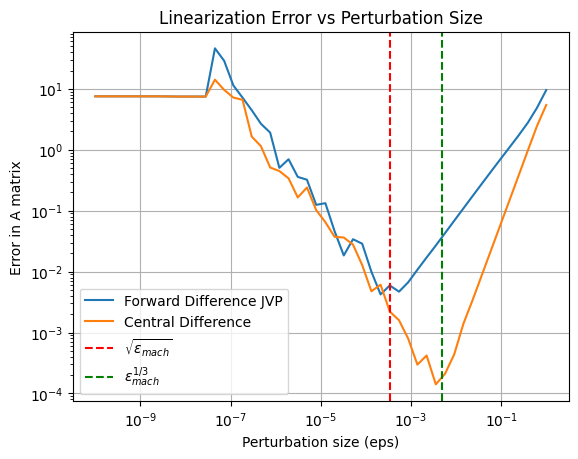

In [141]:
# Check linearization error
key = jax.random.PRNGKey(10)
x_rand = jax.random.uniform(key, shape=(4,), minval=-jnp.pi, maxval=jnp.pi)
u_rand = jax.random.uniform(key, shape=(1,), minval=-1.0, maxval=1.0)

eps_vals = jnp.logspace(-10, 0, num=50)
A, B = linearize_ad(f_double_pendulum_continuous, x_rand, u_rand)

As_fd, _ = jax.vmap(lambda eps: linearize_forward(f_double_pendulum_continuous, x_rand, u_rand, eps))(eps_vals)
As_cd, _ = jax.vmap(lambda eps: linearize_central(f_double_pendulum_continuous, x_rand, u_rand, eps))(eps_vals)

A_error_fd = jnp.linalg.norm(As_fd - A, axis=(1, 2))
A_error_cd = jnp.linalg.norm(As_cd - A, axis=(1, 2))

plt.loglog(eps_vals, A_error_fd, label='Forward Difference JVP')
plt.loglog(eps_vals, A_error_cd, label='Central Difference')
plt.xlabel('Perturbation size (eps)')
plt.ylabel('Error in A matrix')
plt.title('Linearization Error vs Perturbation Size')
plt.legend()
plt.grid(True)

#
plt.axvline(x=jnp.sqrt(jnp.finfo(A_error_fd.dtype).eps), color='r', linestyle='--', label='$\sqrt{\\epsilon_{mach}}$')
plt.axvline(x=jnp.power(jnp.finfo(A_error_fd.dtype).eps, 1/3), color='g', linestyle='--', label='$\\epsilon_{mach}^{1/3}$')
plt.legend()
plt.show()